In this article ,I will mainly demonstrate the concept of Projective Measurements and why we need this.
By Li.Jiahao.

# Projective Measurements

## 1.Projection and Born Rule
Born Rule:It states that the probability of a particular result is proportional to the modulus squared of the amplitude or coefficient of that state in the system's wave function(cited from gemini's conclusion.).

Let's review the previous articles, I explained the physics significance about the Z-axis of Bloch Sphere. And I also described the relationship between measuring probability and projection onto Z-axis. Now let's revisit the concept by mathematical derivaton.

## 2.Probability and state after measuring
Let's define a projection matrix: $\Pi$
$$
\Pi = \Pi^{\dagger} \\
\Pi = \Pi^2 \\
$$
Supposed that $\Pi$ projects onto the basis state $|k \rangle$. i.e.,$\Pi = |k\rangle\langle k|$ .

Now consider a collection {$\Pi_0,\Pi_1...\Pi_{m-1} $} that describes a projective measurement if it satisfies the completeness relation: 
$$
\Pi_0 + \dots + \Pi_{m-1} = \mathbb{I}
$$
It means that if you add all the shadows(vector addition), you can recovery the initial vector.
If we measure a system $X$ while it is in a state $\psi\rangle$, the probability of outcome k is given by:
$$ \text{Pr}(\text{outcome is } k) = || \Pi_k |\psi\rangle ||^2 $$
Since :
$$ \Pi_k |\psi\rangle = |k\rangle\langle k | \psi\rangle = c_k |k\rangle $$
We have:
$$ || \Pi_k |\psi\rangle ||^2 = || c_k |k\rangle ||^2 $$
$$ = |c_k|^2 \langle k | k \rangle = |c_k|^2  $$
After the measurement, the state evolves into :
$$ \frac{\Pi_k |\psi\rangle}{|| \Pi_k |\psi\rangle ||} $$



## 3.Implementing projective measurements
Arbitrary projective measurement can be implemented by unitary operation, standard basis measurement and an extra workspace system.

Note: 
* The reason  we need an extra workspace system, is that the hardware is physically limited. We can typically only obtain the outcomes(0 or 1). If we want to extract informaton defined by arbitrary projectors(such as the phase), we must use a unitary operator to map the information to the extra system.

For simplicity, we introduce an auxiliary system $Y$ , and initialize it in the state $|0 \rangle$.


Define the operator M as follows:
$$ M = \sum_{k=0}^{m-1} |k\rangle\langle 0| \otimes \Pi_k $$
The left part $|k\rangle\langle 0| $ acts on $Y$ , and the right part acts on $X$.It can be represented as block matrix form as: 

$$ M = \begin{pmatrix} \Pi_0 & 0 & \cdots \\ \Pi_1 & 0 & \cdots \\ \vdots & \vdots & \ddots \end{pmatrix} $$

The matrix M obviously is not a unitary matrix. However, since the column blocks corresponding to input $|0\rangle_Y$ are normalized and orthogonal, M describes an isometry.Since system $Y$ is initialized in |0⟩ (meaning only the first block column participates in the calculation), we can extent this matrix to a full unitary U by filling in the remaining columns .Just like:
$$ M = \begin{pmatrix} \Pi_0 & ? & \cdots \\ \Pi_1 & ? & \cdots \\ \vdots & \vdots & \ddots \end{pmatrix} $$

Everything is ready, we apply M to the system $(Y,X)$:
$$
U(|0\rangle|\phi\rangle) = M(|0\rangle|\phi\rangle) = \sum_{k=0}^{m-1} |k\rangle \otimes \Pi_k|\phi\rangle,
$$
If we measure $Y$, We  obtain outcome $|k\rangle$ with probability with
$$
\| \Pi_k |\phi\rangle \|^2
$$
System $(Y,X)$ collapses into 
$$
|k\rangle \otimes \frac{\Pi_k |\phi\rangle}{\| \Pi_k |\phi\rangle \|}.$$

<IPython.core.display.Latex object>

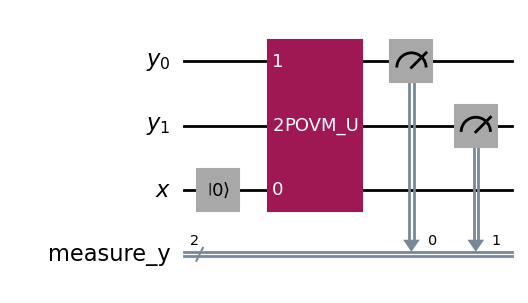

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [ ]:
#In this case, I measure a qubit in 4 different directions (Z-up, Z-down, X-plus, X-minus) using POVM .
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex
from IPython.display import display, Latex, Math
from scipy.linalg import null_space
from qiskit.circuit.library import UnitaryGate
# ==========================================
# 1. define 4 direction we need (POVM )
# ==========================================
# sum(M_k^dag M_k) = I
# ==========================================

P0 = np.array([[1, 0], [0, 0]])
P1 = np.array([[0, 0], [0, 1]])
P_plus = 0.5 * np.array([[1, 1], [1, 1]])
P_minus = 0.5 * np.array([[1, -1], [-1, 1]])

# Construct POVM operators M_k = P_k / sqrt(2)
M = [
    1/np.sqrt(2) * P0,      
    1/np.sqrt(2) * P1,      
    1/np.sqrt(2) * P_plus,  
    1/np.sqrt(2) * P_minus  
]

# ==========================================
# 2. Construct unitary matrix U 
# ==========================================

# Initialize an 8x2 matrix (Isometry)
# Each block corresponds to |k>_Y \otimes M_k
col_0 = [] # Corresponds to input |00>|0>_x
col_1 = [] # Corresponds to input |00>|1>_x
for k in range(4):
    col_0.extend(M[k][:, 0]) 
    col_1.extend(M[k][:, 1])

isometry = np.column_stack((col_0, col_1))

# Extend to 8x8 unitary matrix
# Use the null space to complete the remaining 6 columns to form an orthogonal matrix
null_space_basis = null_space(isometry.conj().T)
unitary_matrix = np.hstack((isometry, null_space_basis))

# test if unitary
is_unitary = np.allclose(unitary_matrix @ unitary_matrix.conj().T, np.eye(8))
display(Latex(f"Unitary Matrix Constructed Successfully: \\textbf{{{is_unitary}}}"))

# ==========================================
# 3. quantum circuit 
# ==========================================
reg_y = QuantumRegister(2, 'y')
reg_x = QuantumRegister(1, 'x')
creg = ClassicalRegister(2, 'measure_y')

qc = QuantumCircuit(reg_y, reg_x, creg)
qc.reset(reg_x) 
# [LSB, Middle, MSB]
qc.append(UnitaryGate(unitary_matrix, label="POVM_U"), [reg_x[0], reg_y[0], reg_y[1]])

qc.measure(reg_y, creg)
display(qc.draw('mpl'))
# ==========================================
# 4. Statevector Simulation
# ==========================================

qc_no_meas = qc.remove_final_measurements(inplace=False)
final_state = Statevector(qc_no_meas)

# Calculate the probabilities of measuring Y in states 00, 01, 10, 11
probs = final_state.probabilities_dict(qargs=[0, 1]) # qargs=[0,1] correspond to the two qubits of Y

display(Latex("### Measurement Results (Probabilities)"))
display(Latex("The 4 directions (projections) we are measuring:"))
display(Latex(r"$k=00: |0\rangle\langle 0|$ (Z-up)"))
display(Latex(r"$k=01: |1\rangle\langle 1|$ (Z-down)"))
display(Latex(r"$k=10: |+\rangle\langle +|$ (X-plus)"))
display(Latex(r"$k=11: |-\rangle\langle -|$ (X-minus)"))

display(Latex("---"))
display(Latex(f"**Initial State of X:** $|0\\rangle$"))

data = []
labels = ["00 (Z+)", "01 (Z-)", "10 (X+)", "11 (X-)"]
sorted_keys = sorted(probs.keys())

out_str = r"\begin{array}{|c|c|c|} \hline \text{Outcome (Y)} & \text{Direction} & \text{Probability} \\ \hline "

for i, key in enumerate(['00', '01', '10', '11']):
    val = probs.get(key, 0.0)
    out_str += f"{key} & {labels[i]} & {val:.4f} \\\\ "

out_str += r"\hline \end{array}"

display(Math(out_str))

